# Immersion Window Comparison - H2O

### Imports

In [1]:
import h2o
from h2o.estimators import H2ODeepLearningEstimator
import pandas as pd
import numpy as np
import glob
import re
import matplotlib.pyplot as plt

h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,1 day 22 hours 59 mins
H2O_cluster_timezone:,Europe/London
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.1.3
H2O_cluster_version_age:,1 month and 22 days
H2O_cluster_name:,H2O_from_python_alexzamar_r2ignr
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,99.2 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


### Build, train, and cross-validate models

In [96]:
files = glob.glob('../Data/Reduced/IMM*.csv')

for f in files:
    # Load data
    data = h2o.import_file(f, header=1)
    data['Dive'] = data['Dive'].asfactor()
    data['BirdID'] = data['BirdID'].asfactor()
    
    # Extract model ID from filepath
    wdw = re.search(r"/IMM(\d+)_reduced", f).group(1)
    idd = 'IMM_window_' + wdw
    
    # Build and train the model:
    dl_cross = H2ODeepLearningEstimator(model_id = idd,
                                        distribution = "bernoulli",
                                        hidden = [200, 200],
                                        fold_column = 'BirdID',
                                        keep_cross_validation_models = True,
                                        keep_cross_validation_fold_assignment = True,
                                        keep_cross_validation_predictions = True,
                                        score_each_iteration = True,
                                        epochs = 50,
                                        train_samples_per_iteration = -1,
                                        activation = "RectifierWithDropout",
                                        input_dropout_ratio = 0.2,
                                        hidden_dropout_ratios = [0.2, 0.2],
                                        single_node_mode = False,
                                        balance_classes = False,
                                        force_load_balance = False,
                                        seed = 23123,
                                        score_training_samples = 0,
                                        score_validation_samples = 0,
                                        stopping_rounds = 0)

    dl_cross.train(x = data.columns[1:-1],
                   y="Dive",
                   training_frame=data)
    
    # Save model
    h2o.save_model(model=dl_cross, path="../Results/Reduced/H2O_IMM_XVal_Models/", force=True)

Parse progress: |█████████████████████████████████████████████████████████| 100%
deeplearning Model Build progress: |██████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
deeplearning Model Build progress: |██████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
deeplearning Model Build progress: |██████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
deeplearning Model Build progress: |██████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
deeplearning Model Build progress: |██████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
deeplearning Model Build progress: |██████████████████████████████████████| 100%


### Evaluate models

In [28]:
files = glob.glob('../Data/Reduced/IMM*.csv')
f = files[0]

In [30]:
dta = pd.read_csv(f)

In [32]:
dta.shape

(94262, 22)

In [3]:
# Retrieve file paths
models = glob.glob('../Results/Reduced/H2O_IMM_XVal_Models/*')
mod_pth = models[0]
model = h2o.load_model(mod_pth)


In [20]:
import numpy as np

In [23]:
np.array(model.confusion_matrix().to_list())

array([[78918, 10722],
       [ 3818, 81698]])

In [25]:
conf_matrix = np.array(model.confusion_matrix().to_list())
truepos, falsepos, falseneg, trueneg = conf_matrix.flatten()

In [33]:
model

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  window_300


Status of Neuron Layers: predicting Dive, 2-class classification, bernoulli distribution, CrossEntropy loss, 50,802 weights/biases, 615.2 KB, 8,757,800 training samples, mini-batch size 1


,,layer,units,type,dropout,l1,l2,mean_rate,rate_rms,momentum,mean_weight,weight_rms,mean_bias,bias_rms
0,,1,50,Input,20.0,,,,,,,,,
1,,2,200,RectifierDropout,20.0,0.0,0.0,0.001461,0.001221,0.0,0.001342,0.136182,-0.916054,0.297122
2,,3,200,RectifierDropout,20.0,0.0,0.0,0.026823,0.070817,0.0,-0.061545,0.197899,-0.156202,0.385157
3,,4,2,Softmax,,0.0,0.0,0.016121,0.017351,0.0,-0.028343,0.911789,0.027049,0.376434




ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.06437859309076444
RMSE: 0.25372936978356375
LogLoss: 0.22221965038703356
Mean Per-Class Error: 0.08212919814656283
AUC: 0.9675514257867179
AUCPR: 0.9685645048699804
Gini: 0.9351028515734359

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.1382811102545262: 


,,0,1,Error,Rate
0,0,78918.0,10722.0,0.1196,(10722.0/89640.0)
1,1,3818.0,81698.0,0.0446,(3818.0/85516.0)
2,Total,82736.0,92420.0,0.083,(14540.0/175156.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.138281,0.918285,382.0
1,max f2,0.090382,0.942403,395.0
2,max f0point5,0.679033,0.918295,251.0
3,max accuracy,0.138281,0.916988,382.0
4,max precision,0.999979,0.999646,0.0
5,max recall,0.026600,1.000000,399.0
6,max specificity,0.999979,0.999955,0.0
7,max absolute_mcc,0.138281,0.836790,382.0
8,max min_per_class_accuracy,0.587815,0.911923,306.0
9,max mean_per_class_accuracy,0.138281,0.917871,382.0



Gains/Lift Table: Avg response rate: 48.82 %, avg score: 47.33 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010003,1.000000,2.048225,2.048225,1.000000,1.000000,1.000000,1.000000,0.020487,0.020487,104.822489,104.822489,0.020487
1,2,0.020022,1.000000,2.048225,2.048225,1.000000,1.000000,1.000000,1.000000,0.020522,0.041010,104.822489,104.822489,0.041010
2,3,0.030008,0.999998,2.048225,2.048225,1.000000,0.999999,1.000000,1.000000,0.020452,0.061462,104.822489,104.822489,0.061462
3,4,0.040010,0.999993,2.048225,2.048225,1.000000,0.999996,1.000000,0.999999,0.020487,0.081950,104.822489,104.822489,0.081950
4,5,0.050018,0.999971,2.047056,2.047991,0.999430,0.999983,0.999886,0.999996,0.020487,0.102437,104.705648,104.799110,0.102426
5,6,0.100031,0.998834,2.045653,2.046822,0.998744,0.999636,0.999315,0.999816,0.102308,0.204745,104.565292,104.682208,0.204611
6,7,0.150003,0.992620,2.039801,2.044483,0.995887,0.996299,0.998173,0.998644,0.101934,0.306679,103.980080,104.448299,0.306144
7,8,0.200027,0.977586,2.027420,2.040216,0.989843,0.985886,0.996090,0.995454,0.101420,0.408099,102.742005,104.021579,0.406571
8,9,0.300018,0.894686,1.967999,2.016147,0.960831,0.943310,0.984339,0.978075,0.196782,0.604881,96.799866,101.614708,0.595700
9,10,0.400015,0.722586,1.786160,1.958654,0.872053,0.814745,0.956269,0.937245,0.178610,0.783491,78.615969,95.865434,0.749310




ModelMetricsBinomial: deeplearning
** Reported on cross-validation data. **

MSE: 0.0694693556878838
RMSE: 0.26357039987047826
LogLoss: 0.24555072780227408
Mean Per-Class Error: 0.08241854096461299
AUC: 0.9614033708360945
AUCPR: 0.9550554798413163
Gini: 0.922806741672189

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3657646728568356: 


,,0,1,Error,Rate
0,0,79045.0,10595.0,0.1182,(10595.0/89640.0)
1,1,3990.0,81526.0,0.0467,(3990.0/85516.0)
2,Total,83035.0,92121.0,0.0833,(14585.0/175156.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.365765,0.917894,359.0
1,max f2,0.232162,0.947183,380.0
2,max f0point5,0.685938,0.904571,258.0
3,max accuracy,0.378085,0.916743,357.0
4,max precision,0.999933,0.997487,0.0
5,max recall,0.013956,1.000000,399.0
6,max specificity,0.999933,0.999900,0.0
7,max absolute_mcc,0.378085,0.836044,357.0
8,max min_per_class_accuracy,0.642721,0.902170,286.0
9,max mean_per_class_accuracy,0.378085,0.917581,357.0



Gains/Lift Table: Avg response rate: 48.82 %, avg score: 48.64 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010025,0.999972,2.043559,2.043559,0.997722,0.999994,0.997722,0.999994,0.020487,0.020487,104.355923,104.355923,0.020443
1,2,0.020022,0.999793,2.042376,2.042969,0.997144,0.999903,0.997434,0.999948,0.020417,0.040905,104.237616,104.296854,0.040804
2,3,0.030013,0.999409,2.040032,2.041991,0.996000,0.999624,0.996956,0.999840,0.020382,0.061287,104.003199,104.199100,0.061108
3,4,0.040016,0.998576,2.024843,2.037705,0.988584,0.999025,0.994864,0.999637,0.020254,0.081540,102.484333,103.770469,0.081139
4,5,0.050024,0.997422,2.033036,2.036771,0.992584,0.998059,0.994408,0.999321,0.020347,0.101887,103.303555,103.677054,0.101341
5,6,0.100019,0.986286,2.012907,2.024842,0.982757,0.992713,0.988584,0.996018,0.100636,0.202524,101.290664,102.484200,0.200292
6,7,0.150009,0.967740,1.985768,2.011821,0.969507,0.977488,0.982226,0.989843,0.099268,0.301791,98.576760,101.182067,0.296582
7,8,0.200016,0.940311,1.970355,2.001454,0.961982,0.955129,0.977165,0.981164,0.098531,0.400323,97.035540,100.145376,0.391398
8,9,0.300001,0.861188,1.919575,1.974165,0.937190,0.903824,0.963842,0.955388,0.191929,0.592252,91.957490,97.416496,0.571056
9,10,0.400192,0.737921,1.779548,1.925441,0.868824,0.802697,0.940054,0.917161,0.178294,0.770546,77.954783,92.544127,0.723669




Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.92433226,0.0357239,0.96730155,0.92750394,0.9302256,0.8678204,0.92880976
1,auc,0.96374846,0.016398454,0.98399717,0.97217685,0.9628974,0.9396688,0.9600022
2,err,0.07566777,0.0357239,0.03269848,0.07249609,0.06977441,0.13217962,0.07119025
3,err_count,2886.4,1857.6198,479.0,2406.0,2329.0,5484.0,3734.0
4,f0point5,0.90809494,0.043907233,0.95739156,0.9248239,0.91014636,0.837451,0.910662
5,f1,0.9260869,0.03179878,0.966945,0.9252377,0.93212485,0.8777857,0.92834115
6,f2,0.94529134,0.022387473,0.976691,0.9256519,0.9551911,0.92220235,0.9467203
7,lift_top_group,2.0373297,0.02849173,2.056,2.0211852,2.0271468,2.0057683,2.0765479
8,logloss,0.23028703,0.07276283,0.12638009,0.22617611,0.24216105,0.33128038,0.2254375
9,max_per_class_error,0.10978631,0.06499121,0.04784689,0.07407177,0.10967895,0.2178479,0.09948605



Scoring History: 


,,timestamp,duration,training_speed,epochs,iterations,samples,training_rmse,training_logloss,training_r2,training_auc,training_pr_auc,training_lift,training_classification_error
0,,2021-07-03 03:09:59,0.000 sec,None,0.0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,,2021-07-03 03:10:13,51 min 59.237 sec,11885 obs/sec,1.0,1,175156.0,0.336884,0.464471,0.545784,0.920779,0.915659,2.024897,0.124198
2,,2021-07-03 03:10:30,52 min 15.989 sec,12743 obs/sec,2.0,2,350312.0,0.304291,0.324203,0.629423,0.941738,0.935204,2.045887,0.104804
3,,2021-07-03 03:10:47,52 min 32.555 sec,13114 obs/sec,3.0,3,525468.0,0.317036,0.392845,0.597730,0.936717,0.931443,2.044718,0.113350
4,,2021-07-03 03:11:02,52 min 47.711 sec,13649 obs/sec,4.0,4,700624.0,0.286456,0.282865,0.671589,0.950365,0.944920,2.044718,0.095172
5,,2021-07-03 03:11:16,53 min 2.248 sec,14138 obs/sec,5.0,5,875780.0,0.289346,0.289813,0.664930,0.953411,0.948107,2.047058,0.089452
6,,2021-07-03 03:11:31,53 min 16.569 sec,14532 obs/sec,6.0,6,1050936.0,0.289209,0.289203,0.665247,0.949973,0.945397,2.043551,0.096925
7,,2021-07-03 03:11:45,53 min 31.046 sec,14833 obs/sec,7.0,7,1226092.0,0.289087,0.292922,0.665529,0.950706,0.946324,2.044718,0.095309
8,,2021-07-03 03:12:01,53 min 46.346 sec,14899 obs/sec,8.0,8,1401248.0,0.291481,0.311677,0.659967,0.948217,0.942560,2.042386,0.097330
9,,2021-07-03 03:12:14,53 min 59.779 sec,15218 obs/sec,9.0,9,1576404.0,0.281170,0.277034,0.683599,0.953964,0.950148,2.043551,0.092792



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,0,1.000000,1.000000,0.030669
1,1,0.765366,0.765366,0.023473
2,13,0.739029,0.739029,0.022665
3,3,0.733104,0.733104,0.022484
4,8,0.714640,0.714640,0.021917
5,49,0.714558,0.714558,0.021915
6,17,0.710007,0.710007,0.021775
7,36,0.691381,0.691381,0.021204
8,24,0.691177,0.691177,0.021198
9,38,0.689984,0.689984,0.021161



See the whole table with table.as_data_frame()


In [10]:
# Retrieve file paths
models = glob.glob('../Data/Reduced/H2O_IMM_XVal_Models/*')
all_mets = pd.DataFrame(columns=['Accuracy', 'AUC', 'Sensitivity', 'Specificity'])

for mod_pth in models:
    
    wdw = re.match('.*?([0-9]+)$', mod_pth).group(1)  # window size
    
    #print(f'PROCESSING MODEL: {mod_pth}...')
    model = h2o.load_model(mod_pth)
    
    # Pull out X-validation metrics
    metrics = model.cross_validation_metrics_summary().as_data_frame()
    metrics.set_index('', inplace=True)
    metrics = metrics.astype(float)
    
    accuracy = metrics['mean']['accuracy']
    auc = metrics['mean']['auc']
    sensitivity = metrics['mean']['recall']
    specificity = metrics['mean']['specificity']
    
    #conf_matrix = np.array(model.confusion_matrix().to_list())
    #truepos, falsepos, falseneg, trueneg = conf_matrix.flatten()
    
    all_mets.loc[wdw] = [accuracy, auc, sensitivity, specificity]

# Sort and show data
all_mets.sort_index(ascending=True, axis=0, inplace=True)
all_mets.index.name = 'Window (s)'
all_mets

,Accuracy,AUC,Sensitivity,Specificity
Window (s),,,,
120,0.899045,0.928940,0.904088,0.894647
180,0.912163,0.948984,0.945191,0.880581
240,0.920811,0.956735,0.945910,0.896549
300,0.924332,0.963748,0.958844,0.890825
480,0.920994,0.962822,0.971331,0.874496
600,0.923452,0.959010,0.970020,0.878939


### Plot

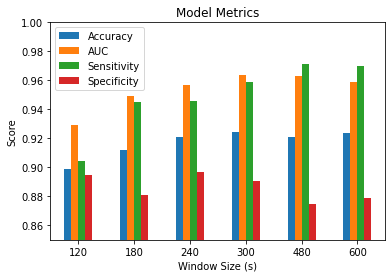

In [12]:
all_mets.plot.bar()

# Furnish plot
plt.xlabel("Window Size (s)")
plt.xticks(rotation=0)
plt.ylabel("Score")
plt.ylim([0.85, 1.0])
plt.title('Model Metrics')

plt.show()

**CONCLUSION:** A window size of 300s (5 mins) attained the highest accuracy and AUC scores predicting dives from immersion data (0.924 and 0.964 respectively)

# Keras

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

In [15]:
all_mets = pd.read_csv('../Results/IMM_WindowComp_xval_metrics_Keras.csv')

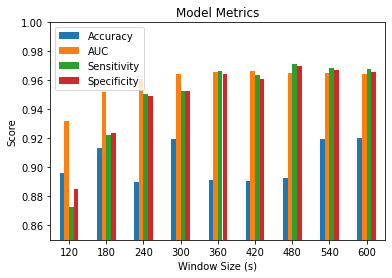

In [16]:
all_mets.set_index('Window Size (s)', inplace=True)
plt_mets = all_mets.iloc[:,:4]

plt_mets.plot.bar()

# Furnish plot
plt.xlabel("Window Size (s)")
plt.xticks(rotation=0)
plt.ylabel("Score")
plt.ylim([0.85, 1.0])
plt.title('Model Metrics')

plt.show()

In [22]:
plt_mets

,Accuracy,AUC,Sensitivity,Specificity
Window Size (s),,,,
120,0.895906,0.931838,0.872913,0.885118
180,0.913270,0.952039,0.922485,0.923594
240,0.889582,0.960598,0.950428,0.949038
300,0.919816,0.964432,0.952415,0.952324
360,0.891299,0.965896,0.966783,0.964213
420,0.890645,0.966428,0.963776,0.961086
480,0.892335,0.965218,0.971074,0.969936
540,0.919816,0.965262,0.968205,0.966859
600,0.920212,0.964629,0.967972,0.966033


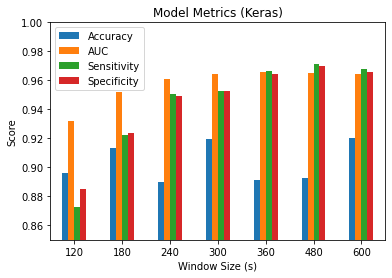

In [31]:
plt_mets.loc[[120, 180, 240, 300, 360, 480, 600]].plot.bar()
# Furnish plot
plt.xlabel("Window Size (s)")
plt.xticks(rotation=0)
plt.ylabel("Score")
plt.ylim([0.85, 1.0])
plt.title('Model Metrics (Keras)')

plt.show()